# IPAI Homework 4. Car Detection and Plotting Trailing

#### Work done by Pavel Tishkin, p.tishkin@innpolis.university

## References

1. https://learnopencv.com/read-write-and-display-a-video-using-opencv-cpp-python/
2. Innopolis University Itroduction to Computer Vision Course Labs

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import copy

In [2]:
plt.rcParams["figure.figsize"] = (60,6)

# Retreiving image of the bridge 

We need the clear picture of the bridge in order to subtract it from each picture to get the boundaries of the cars. It was found that the video is in 60 fps, and seconds 0 and 2 provide us with the left and right side (At about 450 pixel on the horizontal coordinate) of the bridge empty of the cars. Therefore, it is possible to extract the clean picture of the bridge

Image shape - (360, 684, 3)


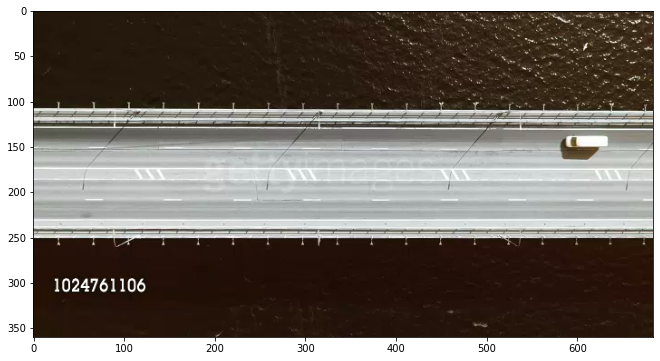

Total number of frames - 1200, fps - 60.0


In [3]:
im1, im2 = None, None

cap = cv2.VideoCapture('video.mp4')

i = 0
while cap.isOpened:
    ret, frame = cap.read()
    if ret:
        i+=1
        # Empirically derived the first frame has free left side of the bridge
        if i == 1:
            print('Image shape -', frame.shape)
            im1 = frame
            plt.imshow(frame)
            plt.show()
        # Empirically derived the 125th frame has free left side of the bridge
        if i == 125:
            im2 = frame
    else:
        break
        
print(f'Total number of frames - {i}, fps - {i/20}')

cap.release()
cv2.destroyAllWindows()

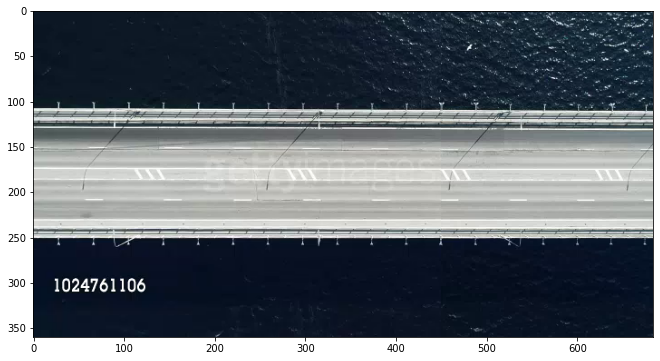

In [4]:
# Concatenating the free parts of the bridge
bridge_kernel = np.concatenate((im1[:, :450], im2[:, 450:]), axis=1)
# Converting to gray for later use
kernel_gray = cv2.cvtColor(bridge_kernel, cv2.COLOR_BGR2GRAY)
# Demonstration of the kernel
plt.imshow(cv2.cvtColor(bridge_kernel, cv2.COLOR_BGR2RGB))
plt.show()

In [6]:
# Following the tutorial on cv2 reading and writing to the video files
cap = cv2.VideoCapture('video.mp4')

frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

out = cv2.VideoWriter('result.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 60, (frame_width,frame_height))

i = 0
# Initializing the picture and array of previous cars for plotting their trails
lines = np.zeros(bridge_kernel.shape, dtype=bridge_kernel.dtype)
prev_c = []
while cap.isOpened:
    # Reading the next frame
    ret, frame = cap.read()
    # If there is a frame
    if ret:
        # Converting the image to gray
        im_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # Subtracting the mask of the bridge from the picture
        unmasked = cv2.absdiff(im_gray, kernel_gray)
        # Thresholding image using otsu method
        ret3,th3 = cv2.threshold(unmasked,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        # Removing water and seagull parts from the image so they will not be accidentally 
        # recognized as boundaries. Also, kernel was not perfect and could merge with the cars in the bottom.
        # Then concatenating with 0 array so that the boundaries will have correct coordinates
        res = np.concatenate((np.zeros((150, th3.shape[1]), dtype = th3.dtype), th3[150:230, :]))
        # Using dillation to fill the boundaries of the cars that are divided into parts
        kernel = np.ones((5,5),np.uint8)
        sas = cv2.dilate(res, kernel, iterations=1)
        # Extracting contours
        contours, hierarchy = cv2.findContours(sas, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # Filtering noisy contours
        filtered_c = list(filter(lambda s: cv2.contourArea(s) > 200, contours))
        # Copyng frame for output
        res = copy.deepcopy(frame)
        # Iterating over all boundaries
        for c in filtered_c:
            # Getting bounding rectangle
            x,y,w,h = cv2.boundingRect(c)
            # Plotting it to the result
            cv2.rectangle(res,(x-10,y-10),(x+w+10,y+h+10),(0,255,0),2)
            # Check if this is the boundary of the same car from the previous frame
            for c2 in prev_c:
                # Extracting previous boundary
                x2,y2,w2,h2 = cv2.boundingRect(c)
                # Change in x coordinate is usually less than 10 pixels
                # Y axis may slightly differ between frames but no more than 5 pixels
                if (abs(x2-x) < 10) and (abs(y2-y) < 5):
                    # Writing the trailing line of the car
                    cv2.line(lines, (x + w//2, y + h//2), (x2 + w2//2 ,y2 + h2//2), (0,128,0), 2)
        # Resulting image is the sum of image with the box and all trailing lines
        out.write(res + lines)
        i+=1
        # Setting contours for the next iteration
        prev_c = filtered_c
    # If there are no more frames
    else:
        break
# Freeing the reader and writer
cap.release()
out.release()

cv2.destroyAllWindows()